In [1]:
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import time
#from jupyterthemes import jtplot
#jtplot.style(theme='gruvboxd')
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import scipy.stats as stats
import pickle
import gc
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# よく使ってる時刻を表示してくれるようになるprint関数のwrapper
def datePrint(*args, **kwargs):
    from datetime import datetime
    print(datetime.now().strftime('[%Y/%m/%d %H:%M:%S] '), end="")
    print(*args, **kwargs)

In [3]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, target, transform=None):
        self.transform = transform
        self.data = data
        self.target = target
   
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        out_data = self.data[index]
        out_target = self.target[index]
        
        return out_data, out_target

In [4]:
class Net(nn.Module):
    def __init__(self, num_layer=48, channel=128):
        super(Net, self).__init__()
        self.activation = F.relu
        self.num_layer = num_layer
        self.channel = channel

        emb_dim=2
        self.embedding = nn.Embedding(4, emb_dim)

        #第一層
        self.convs = nn.ModuleList([nn.Conv1d(in_channels=emb_dim, out_channels=self.channel, kernel_size=5, padding=2, stride=1)])
        self.convs.append(nn.BatchNorm1d(self.channel))
        #第二層以降
        for i in range(1, num_layer):
            #self.convs.append(SkipConnection(in_channels=self.channel, kernel_size=7))
            self.convs.append(nn.Conv1d(in_channels=self.channel, out_channels=self.channel, kernel_size=5, padding=2, stride=1))
            self.convs.append(nn.BatchNorm1d(self.channel))
        #最終層
        self.fc = nn.Linear(1000*self.channel, 1000-4)
        #self.fcc = nn.Linear(996, 996)
        #self.convs.append(nn.Conv1d(in_channels=self.channel, out_channels=1, kernel_size=5))

    def forward(self, x):
        x = self.embedding(x.long())
        x = torch.transpose(x, 1, 2)
        for i, l in enumerate(self.convs):
                x = l(x)
                if(i%2==1):
                    x = self.activation(x)
        y = x
        x = x.view(-1, 1000*self.channel)
        #x = F.relu(self.fc(x))
        x = self.fc(x)
        #x = x.view(x.shape[0], -1)
        return x, y


net = Net().cuda()
optimizer = optim.RMSprop(net.parameters(), lr=1e-3)
criterion = nn.MSELoss().cuda()
epochs = 30


In [ ]:
datePrint("loading input_test")
input_test = pickle.load(open("../data/index1000base/input_test.pkl","rb"))

datePrint("loading target_test")
target_test = pickle.load(open("../data/index1000base/target_test.pkl","rb"))

datePrint("loading input_train")
input_train = pickle.load(open("../data/index1000base/input_train.pkl","rb"))
#input_train_2 = pickle.load(open("../data/onehot1000base/input_train_2.pkl","rb"))
#input_train = torch.cat((input_train_1, input_train_2), dim=0)

target_train = pickle.load(open("../data/index1000base/target_train.pkl","rb"))

In [ ]:
print(input_test.shape)
print(target_test.shape)
print(input_train.shape)
print(target_train.shape)

In [ ]:
class SkipConnection(nn.Module):
    def __init__(self,in_channels=4,kernel_size=5,downsize_scale=2):
        super(SkipConnection, self).__init__()
        self.downconv = nn.Conv1d(in_channels=in_channels, out_channels=in_channels//downsize_scale, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(num_features=in_channels//downsize_scale)
        self.linear = nn.Conv1d(in_channels=in_channels//downsize_scale, out_channels=in_channels//downsize_scale, kernel_size=kernel_size, padding=kernel_size//2)
        self.bn2 = nn.BatchNorm1d(num_features=in_channels//downsize_scale)
        self.drop = nn.Dropout(p=0.3)
        self.upconv = nn.Conv1d(in_channels=in_channels//downsize_scale, out_channels=in_channels, kernel_size=1)
        
    def forward(self,x):
        dx = self.downconv(x)
        dx = self.linear(F.relu(self.bn1(dx)))
        return x + self.upconv(self.drop(F.relu(self.bn2(dx))))

In [ ]:
datanumloss_list = []
datanumcor_list = []
listing = [0]

for abc in listing:
    prm = abc

    train_dataset = Dataset(input_train[0:300000], target_train[0:300000])
    test_dataset = Dataset(input_test, target_test)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32,shuffle=True, num_workers=1)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32,shuffle=True, num_workers=1)
    '''
    class Net(nn.Module):
        def __init__(self, num_layer=32, channel=64):
            super(Net, self).__init__()
            #last_channel = 256 #線形風
            emb_dim = 4
            #self.embedding = nn.Embedding(4, emb_dim) #embedding
            
            #第一層
            self.convs = nn.ModuleList([nn.Conv1d(in_channels=emb_dim, out_channels=channel, kernel_size=5, padding=2)])
            self.convs.append(nn.BatchNorm1d(num_features=channel))
            #第二層以降
            for i in range(1, num_layer):
                self.convs.append(SkipConnection(in_channels=channel, kernel_size=3))
                self.convs.append(SkipConnection(in_channels=channel, kernel_size=7))
                self.convs.append(SkipConnection(in_channels=channel, kernel_size=11))
                self.convs.append(SkipConnection(in_channels=channel, kernel_size=15))
                #self.convs.append(nn.MaxPool1d(kernel_size=5, padding=2, stride=1)) #pooling
                #最終層
            #self.convs.append(nn.Conv1d(in_channels=channel, out_channels=last_channel, kernel_size=5)) #線形風
            self.convs.append(nn.Conv1d(in_channels=channel, out_channels=1, kernel_size=5))

        def forward(self, x):
            #x = self.embedding(x.long()) #embedding
            #x = torch.transpose(x, 1, 2) #embedding

            for i, l in enumerate(self.convs):
                x = l(x)
                if(i==1):
                    x = F.relu(x)
            x = x.view(x.shape[0], -1)
            return x
    
    ''' 
    class Net(nn.Module):
        def __init__(self, num_layer=48, channel=128):
            super(Net, self).__init__()
            self.activation = F.relu
            self.num_layer = num_layer
            self.channel = channel

            emb_dim=2
            self.embedding = nn.Embedding(4, emb_dim)

            #第一層
            self.convs = nn.ModuleList([nn.Conv1d(in_channels=emb_dim, out_channels=self.channel, kernel_size=5, padding=2, stride=1)])
            self.convs.append(nn.BatchNorm1d(self.channel))
            #第二層以降
            for i in range(1, num_layer):
                #self.convs.append(SkipConnection(in_channels=self.channel, kernel_size=7))
                self.convs.append(nn.Conv1d(in_channels=self.channel, out_channels=self.channel, kernel_size=5, padding=2, stride=1))
                self.convs.append(nn.BatchNorm1d(self.channel))
            #最終層
            self.fc = nn.Linear(1000*self.channel, 1000-4)
            #self.fcc = nn.Linear(996, 996)
            #self.convs.append(nn.Conv1d(in_channels=self.channel, out_channels=1, kernel_size=5))
            
        def forward(self, x):
            x = self.embedding(x.long())
            x = torch.transpose(x, 1, 2)
            for i, l in enumerate(self.convs):
                    x = l(x)
                    if(i%2==1):
                        x = self.activation(x)
            y = x
            x = x.view(-1, 1000*self.channel)
            #x = F.relu(self.fc(x))
            x = self.fc(x)
            #x = x.view(x.shape[0], -1)
            return x, y


    net = Net().cuda()
    optimizer = optim.RMSprop(net.parameters(), lr=1e-3)
    criterion = nn.MSELoss().cuda()
    epochs = 30

    print('data num', prm)

    train_loss_list = []
    val_loss_list = []
    tmp = 0
    

    for epoch in tqdm(range(epochs)):
        train_loss = 0
        val_loss = 0

        net.train()
        for data, target in train_dataloader:
            data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output, _ = net(data)
            loss = criterion(output, target)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()

        avg_train_loss = train_loss / len(train_dataloader)
        train_loss_list.append(avg_train_loss)
        #print('Epoch: {};  '.format(epoch))
        #print('train_loss: {:.3f}'.format(avg_train_loss))
        #print('learnig_rate: {}'.format(optimizer.param_groups[0]['lr']))

        #lr_scheduler.step()

        net.eval()
        data_all = []
        target_all = []
        output_all = []
        loss_list = []
        with torch.no_grad():
            for data, target in test_dataloader:
                data, target = data.cuda(), target.cuda()
                output, y = net(data)
                for i in range(len(target)):
                    data_all.append(data[i].cpu().numpy())
                    target_all.append(target[i].cpu().numpy())
                    output_all.append(output[i].cpu().numpy())
                loss = criterion(output, target)
                val_loss += loss.item()


            avg_val_loss = val_loss / len(test_dataloader)
            #if((abs(avg_val_loss-tmp)<1e-4) | (avg_val_loss<0.15)):
            if((avg_val_loss<0.1)):
                val_loss_list.append(avg_val_loss)
                break
            tmp = avg_val_loss
            val_loss_list.append(avg_val_loss)
        print(avg_val_loss)
        print('x', output)
        plt.figure(figsize=(15, 7))
        plt.bar(np.array(range(len(target_all[0])))-0.2 , target[0].cpu().numpy(), label='target', color='b', width=0.4, align='center')
        plt.bar(np.array(range(len(target_all[0])))+0.2 , output[0].cpu().numpy(), label='output', color='r', width=0.4, align='center')
        plt.legend()
        plt.title('cor_max')
        plt.show()
        print(y)
        
    torch.save(net.state_dict(), 'cnn1000_linear')

    plt.plot(range(epoch+1), train_loss_list, label='train')
    plt.plot(range(epoch+1), val_loss_list, label='test')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()


    print('test_loss: {:.3f}'.format(avg_val_loss))
    plt.figure(figsize=(7, 7), dpi=70)
    plt.scatter(target_all, output_all, s=0.1, c='red', marker='.', label='output')
    plt.scatter(target_all, target_all, s=0.1, c='blue', marker='.', label='ideal')
    plt.xlim(0, 15)
    plt.ylim(-0.5, 15)
    plt.xlabel('target')
    plt.ylabel('output')
    plt.legend()
    plt.show()


    loss_list = []    
    cor_list = []
    for n in range(len(target_all)):
        mse = 0
        cor = np.corrcoef(target_all[n], output_all[n])
        cor_list.append(cor[0, 1])
        for m in range(len(target_all[0])):
            mse += (target_all[n][m] - output_all[n][m]) **2
        mse = mse / len(output_all[n])
        loss_list.append(mse)
    plt.hist(cor_list)
    plt.xlim(-1, 1)
    plt.xlabel('correlation coefficient')
    plt.ylabel('count')
    plt.show()
    print(np.average(cor_list))

    plt.scatter(target_all[np.argmax(cor_list)], output_all[np.argmax(cor_list)], label=max(cor_list))
    plt.scatter(target_all[np.argmin(cor_list)], output_all[np.argmin(cor_list)], label=min(cor_list))
    plt.legend()
    plt.show()
    
    
    plt.figure(figsize=(15, 7))
    plt.bar(np.array(range(len(target_all[0])))-0.2 , target_all[np.argmax(cor_list)], label='target', color='b', width=0.4, align='center')
    plt.bar(np.array(range(len(target_all[0])))+0.2 , output_all[np.argmax(cor_list)], label='output', color='r', width=0.4, align='center')
    plt.legend()
    plt.title('cor_max')
    plt.show()


    datanumloss_list.append(avg_val_loss)
    datanumcor_list.append(np.average(cor_list))
plt.plot(listing, datanumloss_list)
plt.xlabel('data num')
plt.ylabel('loss')
plt.show()

plt.plot(listing, datanumcor_list)
plt.xlabel('data num')
plt.ylabel('correlation coefficient')
plt.show()

In [ ]:
plt.figure(figsize=(30, 7))
plt.bar(np.array(range(len(target_all[0])))-0.2 , target_all[np.argmax(cor_list)], label='target', color='b', width=0.4, align='center')
plt.bar(np.array(range(len(target_all[0])))+0.2 , output_all[np.argmax(cor_list)], label='output', color='r', width=0.4, align='center')
plt.legend()
plt.title('cor_max')
plt.show()

plt.figure(figsize=(30, 7))
plt.bar(np.array(range(len(target_all[0])))-0.2 , target_all[np.argmin(cor_list)], label='target', color='b', width=0.4, align='center')
plt.bar(np.array(range(len(target_all[0])))+0.2 , output_all[np.argmin(cor_list)], label='output', color='r', width=0.4, align='center')
plt.legend()
plt.title('cor_min')
plt.show()

plt.figure(figsize=(30, 7))
plt.bar(np.array(range(len(target_all[0])))-0.2 , target_all[np.argmax(loss_list)], label='target', color='b', width=0.4, align='center')
plt.bar(np.array(range(len(target_all[0])))+0.2 , output_all[np.argmax(loss_list)], label='output', color='r', width=0.4, align='center')
plt.legend()
plt.title('loss_max')
plt.show()

plt.figure(figsize=(30, 7))
plt.bar(np.array(range(len(target_all[0])))-0.2 , target_all[np.argmin(loss_list)], label='target', color='b', width=0.4, align='center')
plt.bar(np.array(range(len(target_all[0])))+0.2 , output_all[np.argmin(loss_list)], label='output', color='r', width=0.4, align='center')
plt.legend()
plt.title('loss_min')
plt.show()

In [ ]:
cor_max = []
cor_min = []
loss_max = []
loss_min = []
for i in range(len(data_all[0])):
  if (data_all[np.argmax(cor_list)][i]==0):
    cor_max.append('A')
  elif (data_all[np.argmax(cor_list)][i]==1):
    cor_max.append('U')
  elif (data_all[np.argmax(cor_list)][i]==2):
    cor_max.append('G')
  elif (data_all[np.argmax(cor_list)][i]==3):
    cor_max.append('C')

  if (data_all[np.argmin(cor_list)][i]==0):
    cor_min.append('A')
  elif (data_all[np.argmin(cor_list)][i]==1):
    cor_min.append('U')
  elif (data_all[np.argmin(cor_list)][i]==2):
    cor_min.append('G')
  elif (data_all[np.argmin(cor_list)][i]==3):
    cor_min.append('C')

  if (data_all[np.argmax(loss_list)][i]==0):
    loss_max.append('A')
  elif (data_all[np.argmax(loss_list)][i]==1):
    loss_max.append('U')
  elif (data_all[np.argmax(loss_list)][i]==2):
    loss_max.append('G')
  elif (data_all[np.argmax(loss_list)][i]==3):
    loss_max.append('C')

  if (data_all[np.argmin(loss_list)][i]==0):
    loss_min.append('A')
  elif (data_all[np.argmin(loss_list)][i]==1):
    loss_min.append('U')
  elif (data_all[np.argmin(loss_list)][i]==2):
    loss_min.append('G')
  elif (data_all[np.argmin(loss_list)][i]==3):
    loss_min.append('C')
print('cor_max', ''.join(cor_max))
print('cor_min', ''.join(cor_min))
print('loss_max', ''.join(loss_max))
print('loss_min', ''.join(loss_min))

In [ ]:
'''
import cloudpickle

with open('cnn_only.pkl', 'wb') as f:
    cloudpickle.dump(net, f)
'''

In [5]:
input_val = pickle.load(open("../data/index1000base/input_test.pkl","rb"))
target_val = pickle.load(open("../data/index1000base/target_test.pkl","rb"))
print(input_val.shape)
val_dataset = Dataset(input_val[0:1000], target_val[0:1000])
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=16,shuffle=True, num_workers=1)

net.load_state_dict(torch.load("cnn1000_linear"))
net.eval()
data_all = []
target_all = []
output_all = []
val_loss = 0  
with torch.no_grad():
    start = time.time()
    for data, target in val_dataloader:
        data, target = data.cuda(), target.cuda()
        output, _ = net(data)
        for i in range(len(target)):
            data_all.append(data[i].cpu().numpy())
            target_all.append(target[i].cpu().numpy())
            output_all.append(output[i].cpu().numpy())
        loss = criterion(output, target)
        val_loss += loss.item()
    avg_val_loss = val_loss / len(val_dataloader)
    
    with open('accessibility_output.txt', 'w') as f:
        print(output, file=f)
    finish = time.time()
print('予測時間', (finish-start))

torch.Size([75000, 1000])
予測時間 1.1894209384918213


In [6]:
def plot_result(y_true:np.array, y_est:np.array, lims=[0, 15]) -> None:
    fig,ax = plt.subplots(1,1,dpi=150,figsize=(5,5))
    heatmap, xedges, yedges = np.histogram2d(y_true, y_est, bins=100,range=(lims,lims))
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    cset = ax.imshow(heatmap.T, extent=extent, origin='lower', norm=LogNorm(), cmap='rainbow')
    ax.plot(lims, lims, ls="--", color="black", alpha=0.5, label="ideal")
    plt.ylabel('output')
    plt.xlabel('target')
    ax.legend()
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    fig.colorbar(cset, cax=cax).ax.set_title("count")
    plt.show()
    

test_loss: 0.085


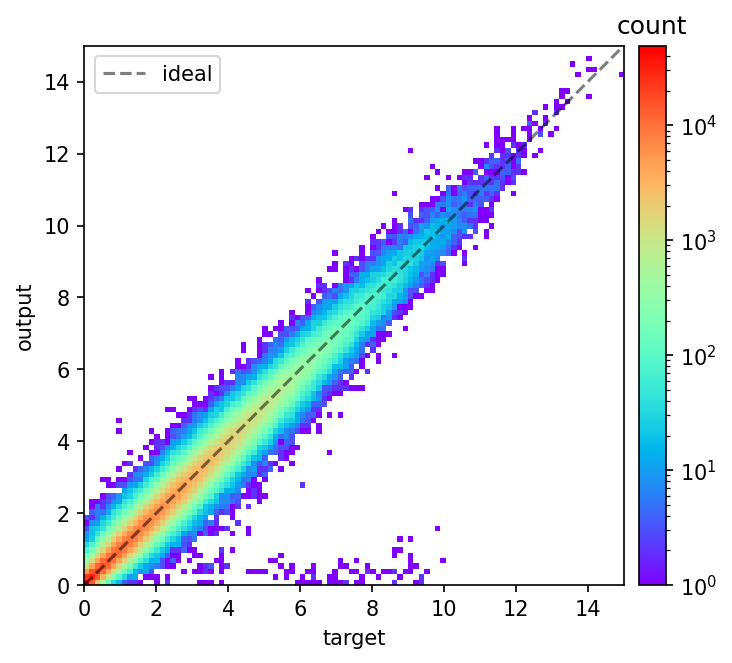

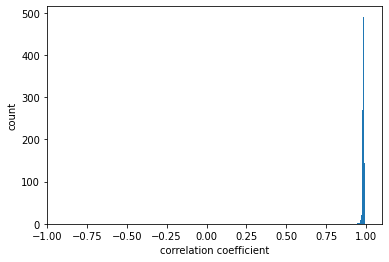

0.9835949641948682


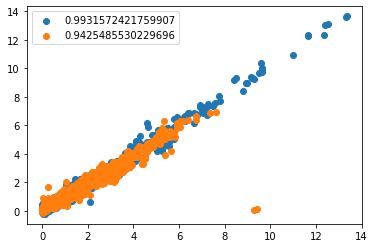

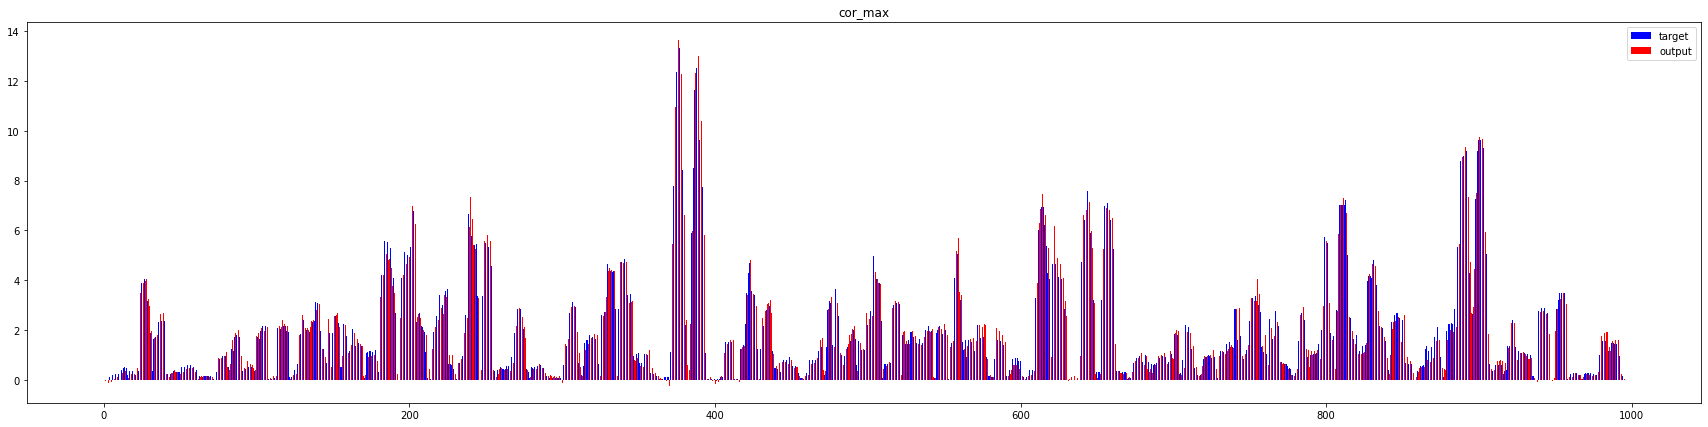

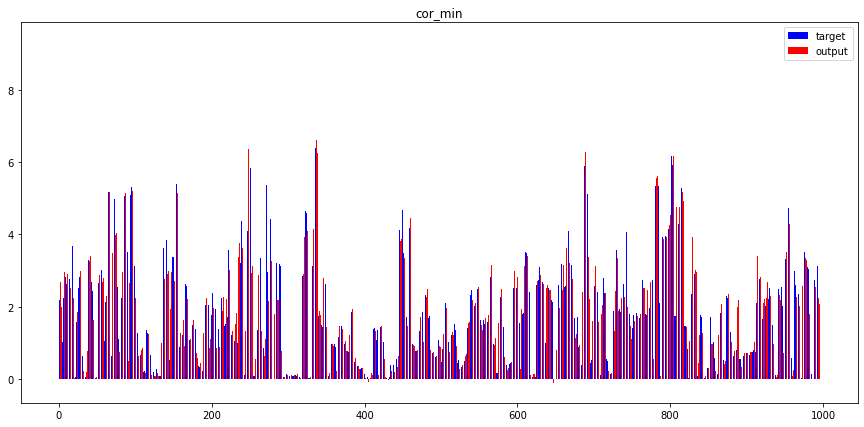

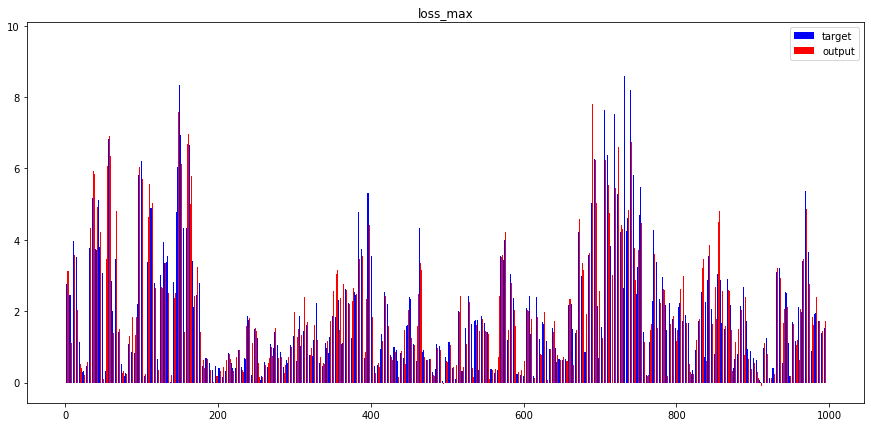

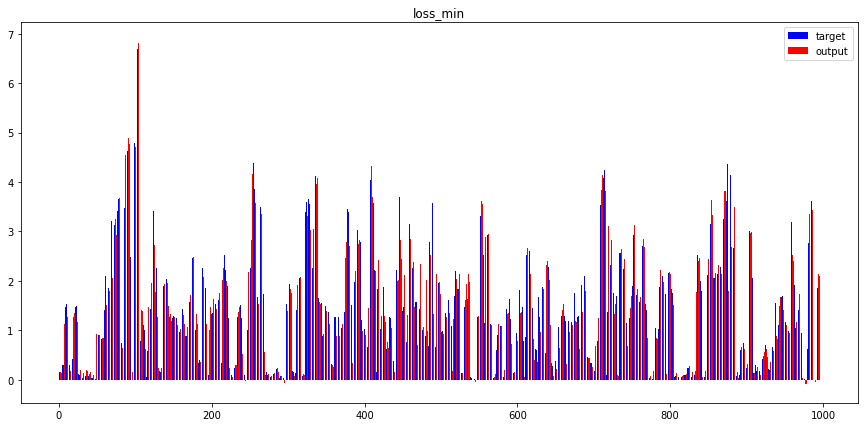

In [7]:
print('test_loss: {:.3f}'.format(avg_val_loss))
'''
plt.figure(figsize=(7, 7), dpi=70)
plt.scatter(target_all, output_all, s=0.1, c='red', marker='.', label='output')
plt.scatter(target_all, target_all, s=0.1, c='blue', marker='.', label='ideal')
plt.xlim(0, 15)
plt.ylim(-0.5, 15)
plt.xlabel('target')
plt.ylabel('output')
plt.legend()
plt.show()
'''
plot_result(np.array(target_all).reshape(-1), np.array(output_all).reshape(-1))

loss_list = []    
cor_list = []
for n in range(len(target_all)):
    mse = 0
    cor = np.corrcoef(target_all[n], output_all[n])
    cor_list.append(cor[0, 1])
    for m in range(len(target_all[0])):
        mse += (target_all[n][m] - output_all[n][m]) **2
    mse = mse / len(output_all[n])
    loss_list.append(mse)
plt.hist(cor_list)
plt.xlim(-1, 1.1)
plt.xlabel('correlation coefficient')
plt.ylabel('count')
plt.show()
print(np.average(cor_list))

plt.scatter(target_all[np.argmax(cor_list)], output_all[np.argmax(cor_list)], label=max(cor_list))
plt.scatter(target_all[np.argmin(cor_list)], output_all[np.argmin(cor_list)], label=min(cor_list))
plt.legend()
plt.show()


plt.figure(figsize=(30, 7))
plt.bar(np.array(range(len(target_all[0])))-0.2 , target_all[np.argmax(cor_list)], label='target', color='b', width=0.4, align='center')
plt.bar(np.array(range(len(target_all[0])))+0.2 , output_all[np.argmax(cor_list)], label='output', color='r', width=0.4, align='center')
plt.legend()
plt.title('cor_max')
plt.show()

plt.figure(figsize=(15, 7))
plt.bar(np.array(range(len(target_all[0])))-0.2 , target_all[np.argmin(cor_list)], label='target', color='b', width=0.4, align='center')
plt.bar(np.array(range(len(target_all[0])))+0.2 , output_all[np.argmin(cor_list)], label='output', color='r', width=0.4, align='center')
plt.legend()
plt.title('cor_min')
plt.show()

plt.figure(figsize=(15, 7))
plt.bar(np.array(range(len(target_all[0])))-0.2 , target_all[np.argmax(loss_list)], label='target', color='b', width=0.4, align='center')
plt.bar(np.array(range(len(target_all[0])))+0.2 , output_all[np.argmax(loss_list)], label='output', color='r', width=0.4, align='center')
plt.legend()
plt.title('loss_max')
plt.show()

plt.figure(figsize=(15, 7))
plt.bar(np.array(range(len(target_all[0])))-0.2 , target_all[np.argmin(loss_list)], label='target', color='b', width=0.4, align='center')
plt.bar(np.array(range(len(target_all[0])))+0.2 , output_all[np.argmin(loss_list)], label='output', color='r', width=0.4, align='center')
plt.legend()
plt.title('loss_min')
plt.show()

In [ ]:
#メモリ確認
import sys

print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 10000: #10M以上のみ表示
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))